In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import norm

# Define paths
is_rsa_dir = '/Volumes/ARCHIVES/thesis_pipeline/data/alignment_matrices_fixed'
between_roi_dir = '/Volumes/ARCHIVES/thesis_pipeline/data/alignment_matrices_fixed_ROI'
roi_names = ['PTL', 'ATL', 'AG', 'IFG', 'MFG', 'IFGorb']
n_subjects = 8


In [2]:
# Load IS-RSA alignment matrices for each ROI and validate dimensions
is_rsa_matrices = {}
for roi in roi_names:
    file_path = os.path.join(is_rsa_dir, f"matchz_{roi}_alignment.npy")
    matrix = np.load(file_path)
    is_rsa_matrices[roi] = matrix
    print(f"Loaded IS-RSA matrix for {roi}: shape {matrix.shape}, sample values:\n{matrix[:2, :2]}")

# Load between-ROI alignment matrices for each subject and validate dimensions
between_roi_matrices = []
for i in range(n_subjects):
    file_path = os.path.join(between_roi_dir, f"subject_{i+1}_region_alignment.npy")
    matrix = np.load(file_path)
    between_roi_matrices.append(matrix)
    print(f"Loaded between-ROI matrix for Subject {i+1}: shape {matrix.shape}, sample values:\n{matrix[:2, :2]}")


Loaded IS-RSA matrix for PTL: shape (8, 8), sample values:
[[0.         1.29682206]
 [1.15367676 0.        ]]
Loaded IS-RSA matrix for ATL: shape (8, 8), sample values:
[[0.         4.07750616]
 [4.20207122 0.        ]]
Loaded IS-RSA matrix for AG: shape (8, 8), sample values:
[[0.         0.2813353 ]
 [0.41006074 0.        ]]
Loaded IS-RSA matrix for IFG: shape (8, 8), sample values:
[[0.         1.17253084]
 [1.16014022 0.        ]]
Loaded IS-RSA matrix for MFG: shape (8, 8), sample values:
[[ 0.         -0.82987618]
 [-0.96966654  0.        ]]
Loaded IS-RSA matrix for IFGorb: shape (8, 8), sample values:
[[ 0.         -0.51021912]
 [-0.47726516  0.        ]]
Loaded between-ROI matrix for Subject 1: shape (6, 6), sample values:
[[0.         5.75313933]
 [6.00272571 0.        ]]
Loaded between-ROI matrix for Subject 2: shape (6, 6), sample values:
[[0.         3.41844945]
 [3.22482307 0.        ]]
Loaded between-ROI matrix for Subject 3: shape (6, 6), sample values:
[[0.         5.590

In [3]:
# Compute average alignment for each ROI (mean of the lower triangle)
def compute_lower_triangle_mean(matrix):
    lower_triangle_values = matrix[np.tril_indices_from(matrix, k=-1)]
    mean_value = np.mean(lower_triangle_values)
    print(f"Lower triangle mean computed: {mean_value} from values:\n{lower_triangle_values[:5]}")  # Show first 5 values
    return mean_value

roi_avg_alignments = {}
for roi, matrix in is_rsa_matrices.items():
    print(f"Computing lower triangle mean for {roi}")
    roi_avg_alignments[roi] = compute_lower_triangle_mean(matrix)

# Compute average between-ROI alignment across subjects
avg_between_roi_matrix = np.mean(between_roi_matrices, axis=0)
print(f"Average between-ROI matrix shape: {avg_between_roi_matrix.shape}")
print(f"Average between-ROI matrix sample values:\n{avg_between_roi_matrix[:2, :2]}")


Computing lower triangle mean for PTL
Lower triangle mean computed: 1.6174561531024971 from values:
[ 1.15367676  2.93634042 -0.46496147  2.00102088  2.05289215]
Computing lower triangle mean for ATL
Lower triangle mean computed: 1.269474797475942 from values:
[4.20207122 4.38166172 0.28122575 3.23097567 2.01674216]
Computing lower triangle mean for AG
Lower triangle mean computed: 1.1723037055418641 from values:
[0.41006074 0.93922789 0.70587652 2.75238036 0.67618787]
Computing lower triangle mean for IFG
Lower triangle mean computed: 0.8728337155061583 from values:
[1.16014022 0.70666279 1.04493201 3.29671983 2.47415548]
Computing lower triangle mean for MFG
Lower triangle mean computed: 0.17561090323280845 from values:
[-0.96966654  1.23832603  0.73333108  2.4775476   1.55700682]
Computing lower triangle mean for IFGorb
Lower triangle mean computed: 0.790540853144827 from values:
[-0.47726516  1.58580764  0.35566468  0.235063   -0.15823495]
Average between-ROI matrix shape: (6, 6)
A

In [ ]:
# Bar plot for ROI average alignments
plt.figure(figsize=(10, 6))
plt.bar(roi_avg_alignments.keys(), roi_avg_alignments.values(), color='skyblue')
plt.xlabel('ROI')
plt.ylabel('Average Alignment (Lower Triangle)')
plt.title('Average Alignment across Subjects by ROI')
plt.show()


In [ ]:
figures_dir = '/Volumes/ARCHIVES/thesis_pipeline/figures/z_allignment_fixed'


p_value_matrix = norm.sf(avg_between_roi_matrix)


# Define significance level
alpha = 0.05

# Create annotations for the heatmap
annotations = np.empty_like(avg_between_roi_matrix, dtype=object)
for i in range(avg_between_roi_matrix.shape[0]):
    for j in range(avg_between_roi_matrix.shape[1]):
        z_score = avg_between_roi_matrix[i, j]
        p_value = p_value_matrix[i, j]
        if i != j:  # Skip diagonal
            annotations[i, j] = f"{z_score:.2f}"
            if p_value < alpha:
                annotations[i, j] += '*'  # Add star for significance
        else:
            annotations[i, j] = ''  # Leave diagonal blank

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(avg_between_roi_matrix, annot=annotations, fmt='', cmap='coolwarm',
            xticklabels=roi_names, yticklabels=roi_names, cbar_kws={'label': 'Z-Score'})
plt.title('Average Between-ROI Alignment with Significance')
plt.xlabel('ROI')
plt.ylabel('ROI')

figure_path = os.path.join(figures_dir, 'avg_between_roi_significance_heatmap.png')
plt.savefig(figure_path, dpi=300)
plt.show()

print(f"Heatmap saved at {figure_path}")


In [ ]:
import networkx as nx

# Initialize the network graph
G = nx.Graph()

# Add nodes (ROIs)
for i, roi in enumerate(roi_names):
    avg_alignment = np.mean(avg_between_roi_matrix[i])  # Compute average alignment per ROI
    G.add_node(roi, avg_alignment=avg_alignment)

# Add edges (z-scores as weights)
for i, roi1 in enumerate(roi_names):
    for j, roi2 in enumerate(roi_names):
        if i < j:  # Only upper triangle to avoid duplicates
            z_score = avg_between_roi_matrix[i, j]
            if z_score > 0:  # Include only positive z-scores
                G.add_edge(roi1, roi2, weight=z_score)

# Compute node strength (weighted degree)
node_strength = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}
sorted_strength = sorted(node_strength.items(), key=lambda x: x[1], reverse=True)

# Display top 3 nodes by strength
top_3_nodes = [node for node, _ in sorted_strength[:3]]
print("Top 3 nodes by strength (weighted degree):")
for node, strength in sorted_strength[:3]:
    print(f"{node}: {strength:.2f}")

# Identify edges connecting the top 3 nodes
highlighted_edges = [
    (u, v) for u, v in G.edges() if u in top_3_nodes and v in top_3_nodes
]

# Generate the graph layout
pos = nx.spring_layout(G, seed=42)  # Seed for consistent layout

# Node color based on average alignment score
node_colors = [G.nodes[roi]['avg_alignment'] for roi in G.nodes()]
node_color_map = plt.cm.viridis

# Normalize node colors for the colormap
norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))

# Draw the network
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=node_color_map, node_size=1500)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw all edges with default color
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=[d['weight'] for (_, _, d) in G.edges(data=True)], alpha=0.7, edge_color='grey')

# Highlight edges connecting the top 3 nodes
nx.draw_networkx_edges(G, pos, edgelist=highlighted_edges, width=3, edge_color='red')

# Add color bar for node colors
sm = plt.cm.ScalarMappable(cmap=node_color_map, norm=norm)
sm.set_array(node_colors)
plt.colorbar(sm, ax=plt.gca(), label='Average Alignment Score')

# Add title and legend for top nodes
plt.title('Network Graph of Between-ROI Alignment (Z-Scores)')

plt.tight_layout()

# Save the figure
figure_path = os.path.join(figures_dir, 'network_graph_top_3_nodes_highlighted_edges.png')
plt.savefig(figure_path, dpi=300)
plt.show()

print(f"Network graph saved at {figure_path}")


In [ ]:
# Compute one-tailed p-values from z-scores
p_value_matrix = norm.sf(avg_between_roi_matrix)

# Define significance level
alpha = 0.05

# Create a boolean matrix indicating significance
significance_matrix = p_value_matrix < alpha

# Print significant between-ROI alignments
print("Significant between-ROI alignments (p < 0.05):")
for i in range(significance_matrix.shape[0]):
    for j in range(significance_matrix.shape[1]):
        if significance_matrix[i, j]:
            print(f"{roi_names[i]} - {roi_names[j]}: p-value = {p_value_matrix[i, j]:.4f}")

# Plot the significance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(significance_matrix, annot=True, cmap="viridis", xticklabels=roi_names, yticklabels=roi_names, cbar=False)
plt.title("Significance Matrix of Between-ROI Alignments (p < 0.05)")
plt.xlabel("ROI")
plt.ylabel("ROI")
plt.show()


Computing lower triangle mean for PTL
Lower triangle mean computed: 1.6174561531024971 from values:
[ 1.15367676  2.93634042 -0.46496147  2.00102088  2.05289215]
Computing lower triangle mean for ATL
Lower triangle mean computed: 1.269474797475942 from values:
[4.20207122 4.38166172 0.28122575 3.23097567 2.01674216]
Computing lower triangle mean for AG
Lower triangle mean computed: 1.1723037055418641 from values:
[0.41006074 0.93922789 0.70587652 2.75238036 0.67618787]
Computing lower triangle mean for IFG
Lower triangle mean computed: 0.8728337155061583 from values:
[1.16014022 0.70666279 1.04493201 3.29671983 2.47415548]
Computing lower triangle mean for MFG
Lower triangle mean computed: 0.17561090323280845 from values:
[-0.96966654  1.23832603  0.73333108  2.4775476   1.55700682]
Computing lower triangle mean for IFGorb
Lower triangle mean computed: 0.790540853144827 from values:
[-0.47726516  1.58580764  0.35566468  0.235063   -0.15823495]


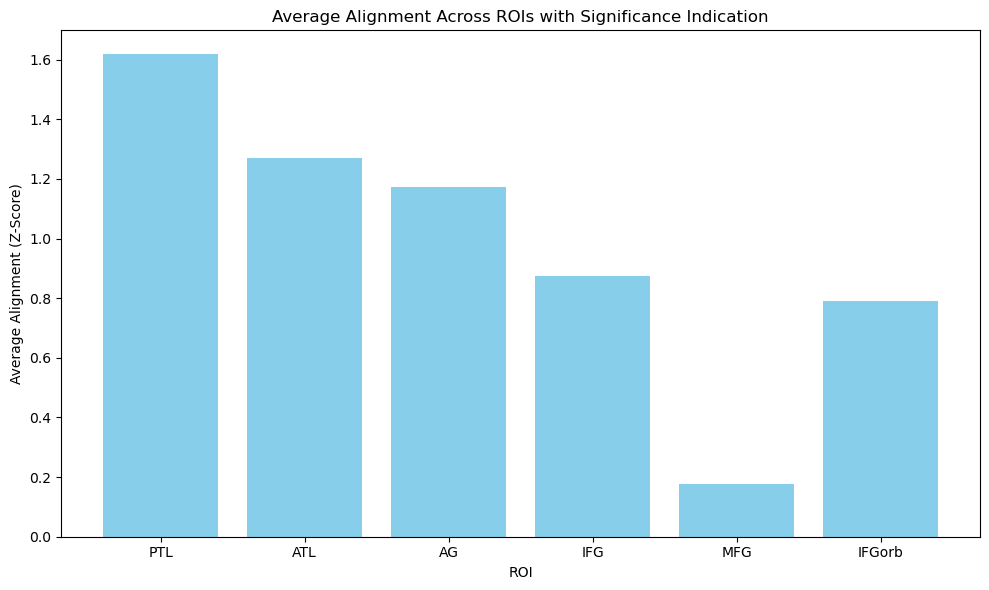

Significance bar plot saved at /Volumes/ARCHIVES/thesis_pipeline/figures/z_allignment_fixed/significance_bar_plot.png


In [4]:
# Define the directory for saving figures
figure_dir = '/Volumes/ARCHIVES/thesis_pipeline/figures/z_allignment_fixed'
os.makedirs(figure_dir, exist_ok=True)

# Compute average alignment for each ROI (mean of the lower triangle)
def compute_lower_triangle_mean(matrix):
    lower_triangle_values = matrix[np.tril_indices_from(matrix, k=-1)]
    mean_value = np.mean(lower_triangle_values)
    print(f"Lower triangle mean computed: {mean_value} from values:\n{lower_triangle_values[:5]}")  # Show first 5 values
    return mean_value

# Example: Replace with actual matrices
# is_rsa_matrices contains ROI z-score matrices
roi_avg_alignments = {}
for roi, matrix in is_rsa_matrices.items():  # Replace `is_rsa_matrices` with actual data
    print(f"Computing lower triangle mean for {roi}")
    roi_avg_alignments[roi] = compute_lower_triangle_mean(matrix)

# Compute one-tailed p-values
roi_names = list(roi_avg_alignments.keys())
avg_values = list(roi_avg_alignments.values())
p_values = norm.sf(avg_values)

# Define significance level
alpha = 0.05

# Create the bar plot with significance stars
plt.figure(figsize=(10, 6))
bars = plt.bar(roi_names, avg_values, color='skyblue')

# Add significance stars
for i, (bar, p_value) in enumerate(zip(bars, p_values)):
    if p_value < alpha:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1,
                 '*', ha='center', va='bottom', fontsize=12, color='red')

# Customize the plot
plt.xlabel('ROI')
plt.ylabel('Average Alignment (Z-Score)')
plt.title('Average Alignment Across ROIs with Significance Indication')
plt.tight_layout()

# Save the figure
figure_path = os.path.join(figure_dir, 'significance_bar_plot.png')
plt.savefig(figure_path, dpi=300)
plt.show()

print(f"Significance bar plot saved at {figure_path}")


In [5]:
for roi, (value, p_value) in zip(roi_names, zip(avg_values, p_values)):
    print(f"ROI: {roi}, Z-Score: {value}, P-Value: {p_value}, Significant: {p_value < alpha}")


ROI: PTL, Z-Score: 1.6174561531024971, P-Value: 0.052889926527444786, Significant: False
ROI: ATL, Z-Score: 1.269474797475942, P-Value: 0.10213588685940161, Significant: False
ROI: AG, Z-Score: 1.1723037055418641, P-Value: 0.12053757220935063, Significant: False
ROI: IFG, Z-Score: 0.8728337155061583, P-Value: 0.19137685982319674, Significant: False
ROI: MFG, Z-Score: 0.17561090323280845, P-Value: 0.43029981796851113, Significant: False
ROI: IFGorb, Z-Score: 0.790540853144827, P-Value: 0.21460598674400833, Significant: False
